In [35]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import zipfile
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')  # Convert to grayscale
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    print(f"Total training images: {len(train_images)}")
    print(f"Total test images: {len(test_images)}")
    
    for participant, data in participant_data.items():
        print(f"Participant {participant}:")
        print(f"  Training images: {len(data['train'][0])}")
        print(f"  Test images: {len(data['test'][0])}")

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

def fine_tune(model, train_loader, test_loader, optimizer, criterion, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_accuracy = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for batch_images, batch_labels in train_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
        
        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
        
        # Evaluate on test set without showing the matrix
        test_accuracy = evaluate(model, test_loader, device, show_matrix=False)
        print(f'Epoch {epoch+1}/{num_epochs}, Test Accuracy: {test_accuracy:.2f}%')
        
        # Save the model if it's the best so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), 'skeptic_v8_finetuned_all_participants.pth')
            print(f'Fine-tuned model saved with accuracy: {best_accuracy:.2f}%')

    # After training is complete, evaluate and show the confusion matrix
    final_accuracy = evaluate(model, test_loader, device, show_matrix=True)
    print(f'Final Test Accuracy: {final_accuracy:.2f}%')

    return model

def evaluate(model, data_loader, device, show_matrix=True):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_images, batch_labels in data_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            outputs = model(batch_images)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    
    if show_matrix:
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()  # This will display the confusion matrix
        plt.savefig('confusion_matrix.png')  # This will save the confusion matrix as an image file
        plt.close()
    
    return accuracy

def evaluate_by_participant(model, participant_data, device):
    model.eval()
    participant_accuracies = {}
    
    for participant, data in participant_data.items():
        test_images, test_labels = data['test']
        test_dataset = ExperimentalDataset(test_images, test_labels)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        accuracy = evaluate(model, test_loader, device)
        participant_accuracies[participant] = accuracy
    
    # Plot participant accuracies
    plt.figure(figsize=(12, 6))
    plt.bar(participant_accuracies.keys(), participant_accuracies.values())
    plt.title('Accuracy by Participant')
    plt.xlabel('Participant')
    plt.ylabel('Accuracy (%)')
    plt.savefig('participant_accuracies.png')
    plt.close()
    
    return participant_accuracies

In [34]:
# Load the pre-trained model
from mnist_skeptic_v8 import NoisyDigitClassifier  # Ensure this import works

In [26]:
# Only use this if the above is not defined or doesn't work
class NoisyDigitClassifier(nn.Module):
    def __init__(self):
        super(NoisyDigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 2 * 2, 256)  # Adjusted for 16x16 input
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [36]:
# Usage example
test_digits_folder = 'test_digits'
train_images, train_labels, test_images, test_labels, participant_data = load_all_experimental_data(test_digits_folder)

train_dataset = ExperimentalDataset(train_images, train_labels)
test_dataset = ExperimentalDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize your model, optimizer, and criterion here
model = NoisyDigitClassifier()  # Your model class
num_epochs = 20
model.load_state_dict(torch.load('saved_models/skeptic_v8.pth'))  # Load the pre-trained model
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) #learning rate scheduler
criterion = nn.CrossEntropyLoss()

Total training images: 13000
Total test images: 40
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 65:
  Training images: 1000
  Test images: 10
Participant 69:
  Training images: 5000
  Test images: 10


C:\Users\saith\AppData\Local\Temp\ipykernel_16700\2639771480.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_models/skeptic_v8.p

Epoch 1/20, Train Loss: 2.5761, Train Accuracy: 10.29%
Epoch 1/20, Test Accuracy: 15.00%
Fine-tuned model saved with accuracy: 15.00%
Epoch 2/20, Train Loss: 2.3988, Train Accuracy: 9.98%
Epoch 2/20, Test Accuracy: 20.00%
Fine-tuned model saved with accuracy: 20.00%
Epoch 3/20, Train Loss: 2.3625, Train Accuracy: 10.18%
Epoch 3/20, Test Accuracy: 20.00%
Epoch 4/20, Train Loss: 2.3426, Train Accuracy: 10.08%
Epoch 4/20, Test Accuracy: 15.00%
Epoch 5/20, Train Loss: 2.3247, Train Accuracy: 10.86%
Epoch 5/20, Test Accuracy: 20.00%
Epoch 6/20, Train Loss: 2.3163, Train Accuracy: 10.85%
Epoch 6/20, Test Accuracy: 20.00%
Epoch 7/20, Train Loss: 2.3126, Train Accuracy: 10.63%
Epoch 7/20, Test Accuracy: 22.50%
Fine-tuned model saved with accuracy: 22.50%
Epoch 8/20, Train Loss: 2.3111, Train Accuracy: 10.67%
Epoch 8/20, Test Accuracy: 22.50%
Epoch 9/20, Train Loss: 2.3050, Train Accuracy: 10.65%
Epoch 9/20, Test Accuracy: 22.50%
Epoch 10/20, Train Loss: 2.3065, Train Accuracy: 10.85%
Epoch 10/

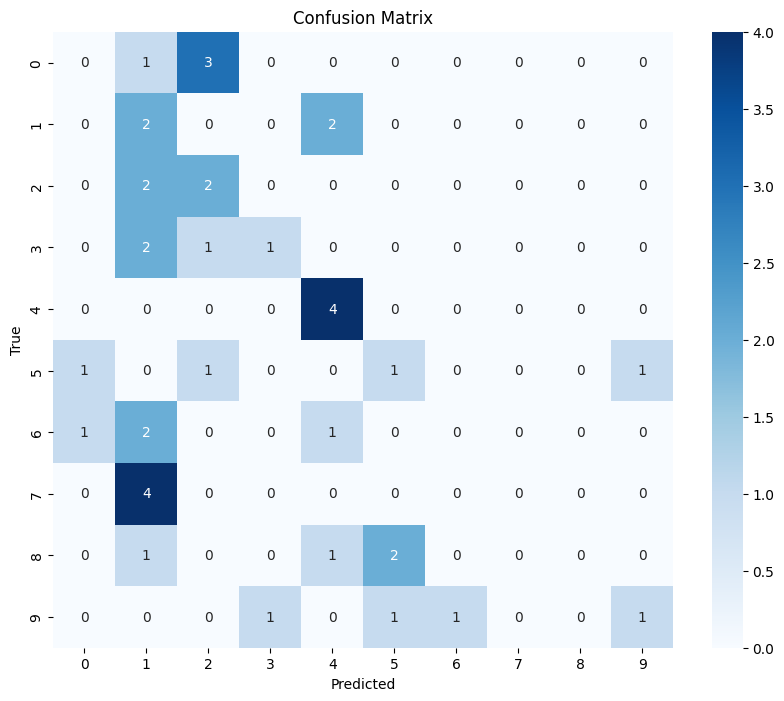

Final Test Accuracy: 27.50%


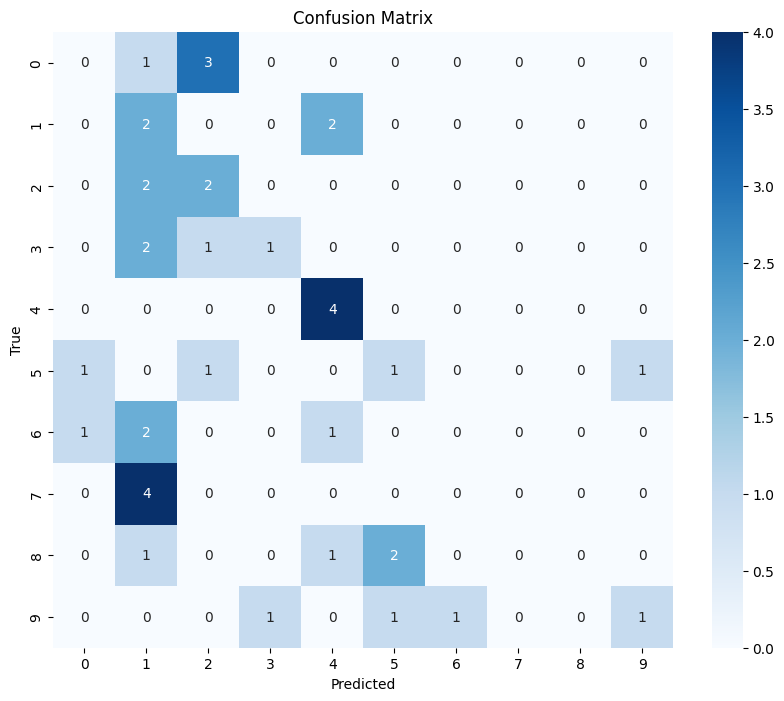

Overall Accuracy: 27.50%


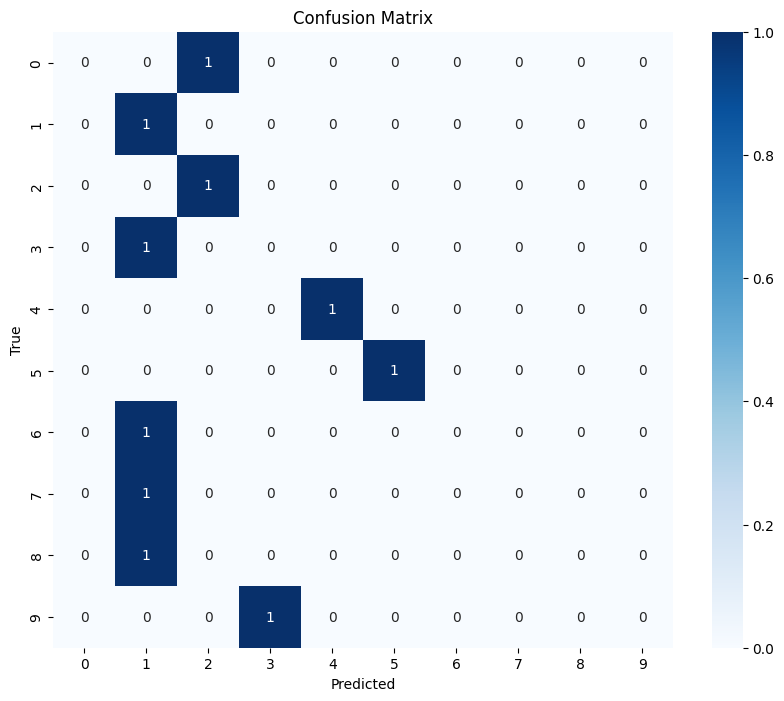

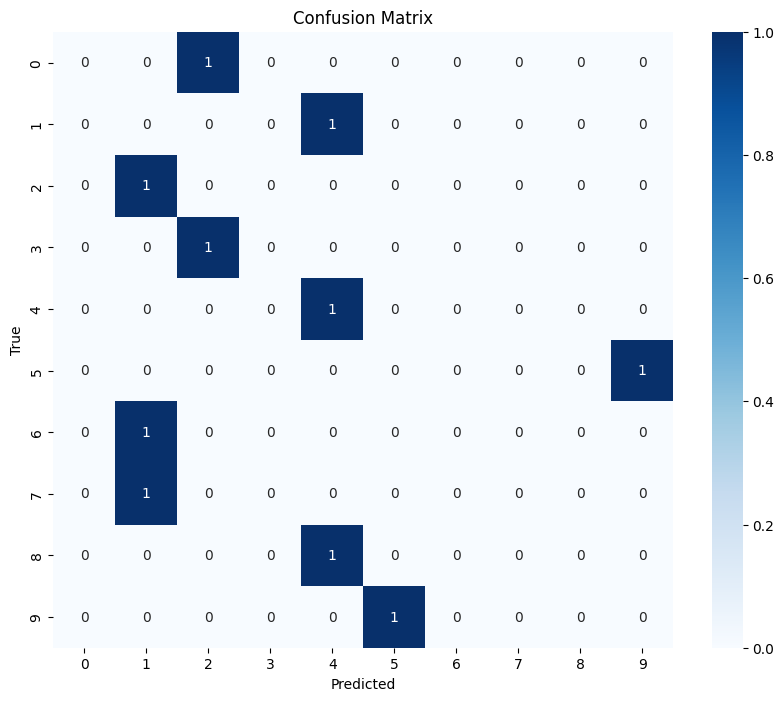

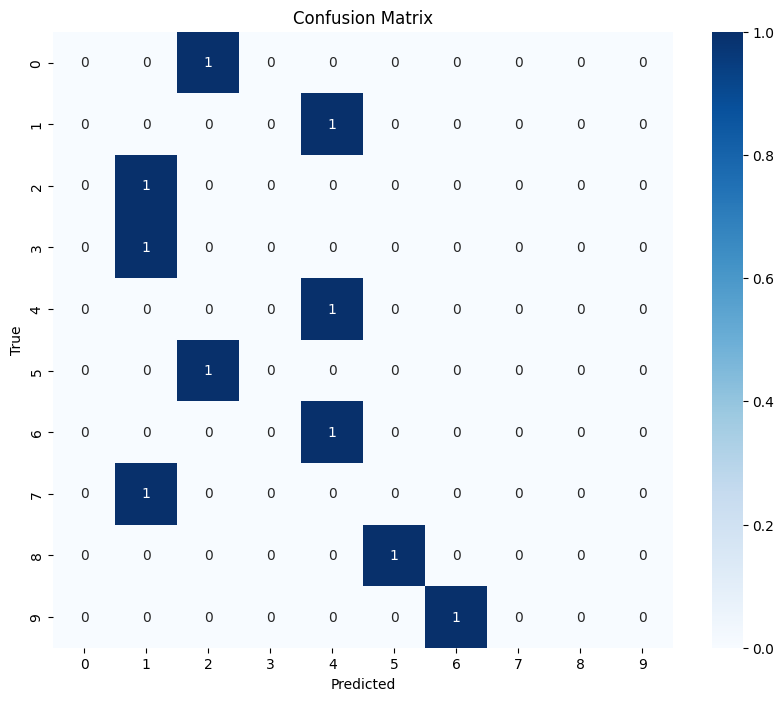

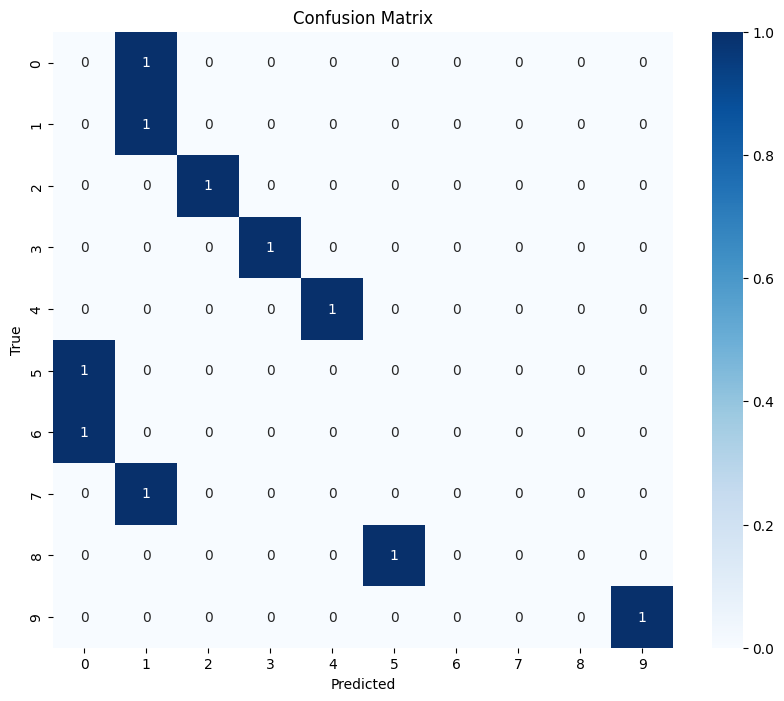

Participant 41 Accuracy: 40.00%
Participant 52 Accuracy: 10.00%
Participant 65 Accuracy: 10.00%
Participant 69 Accuracy: 50.00%


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fine-tune the model
fine_tuned_model = fine_tune(model, train_loader, test_loader, optimizer, criterion, num_epochs=num_epochs)
# Evaluate the model
overall_accuracy = evaluate(fine_tuned_model, test_loader, device)
print(f'Overall Accuracy: {overall_accuracy:.2f}%')

# Evaluate by participant
participant_accuracies = evaluate_by_participant(fine_tuned_model, participant_data, device)
for participant, accuracy in participant_accuracies.items():
    print(f'Participant {participant} Accuracy: {accuracy:.2f}%')

In [ ]:
fine_tuned_model = fine_tune(model, train_loader, test_loader, optimizer, criterion, num_epochs=20)

In [11]:
# If you want to see the confusion matrix again or for specific participants:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

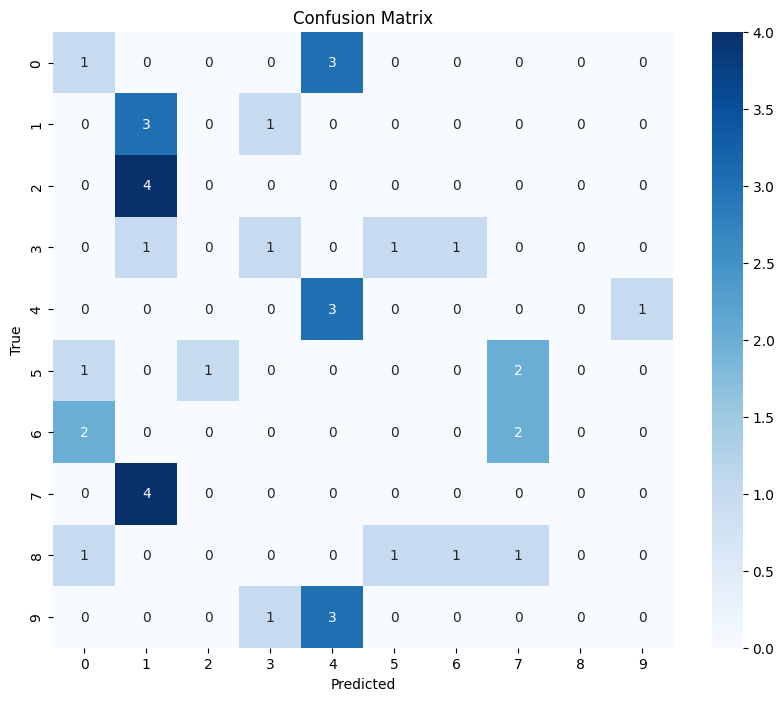

20.0

In [12]:
# Overall evaluation
evaluate(fine_tuned_model, test_loader, device, show_matrix=True)


Evaluating Participant 41


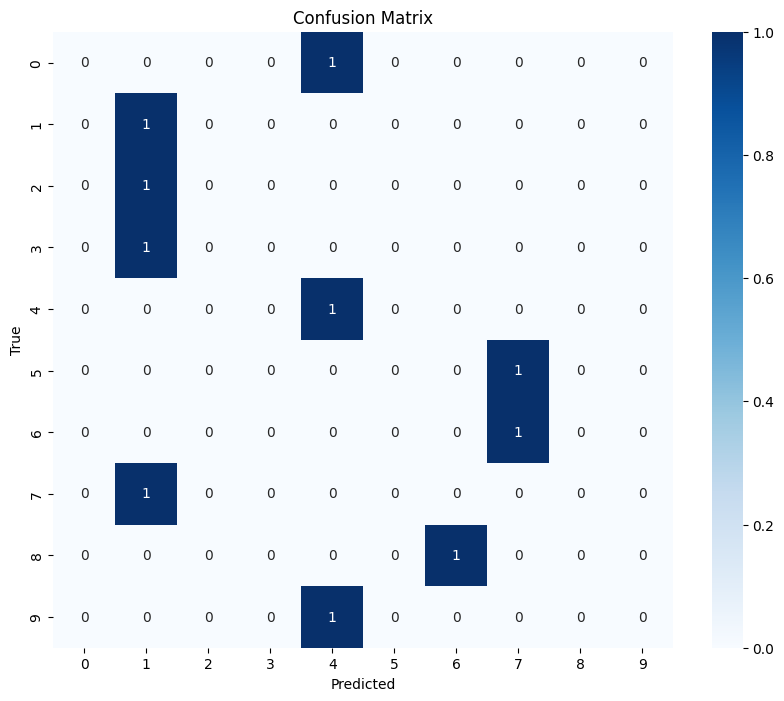

Participant 41 Accuracy: 20.00%

Evaluating Participant 52


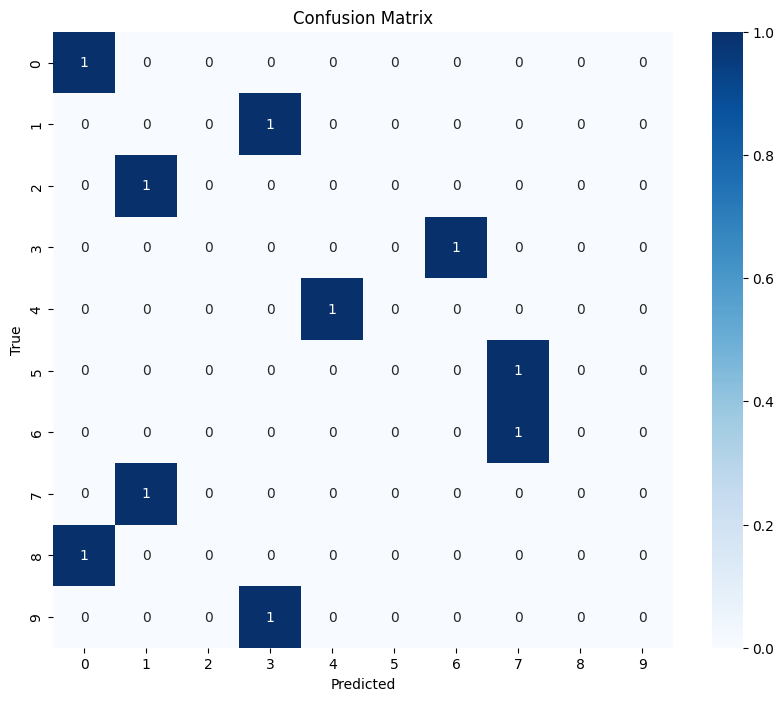

Participant 52 Accuracy: 20.00%

Evaluating Participant 65


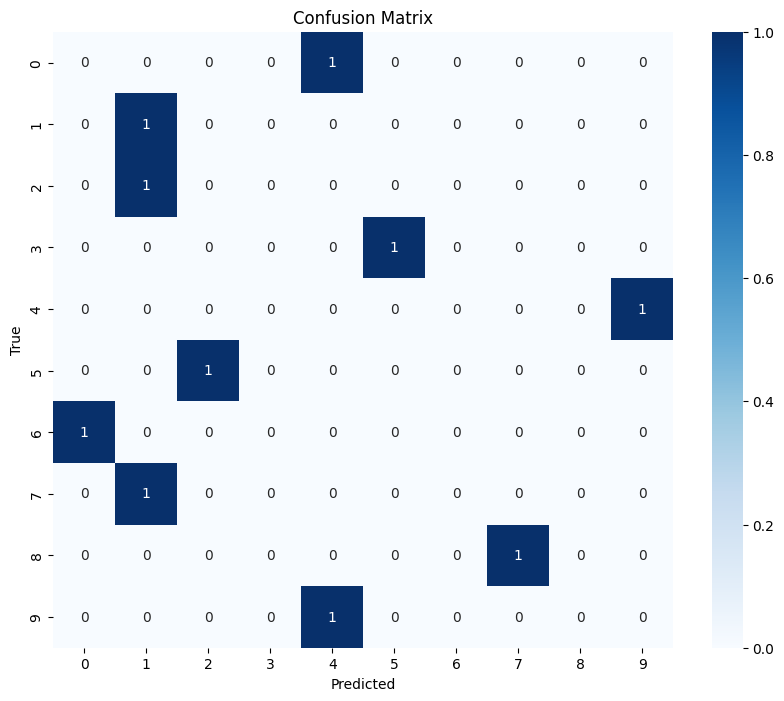

Participant 65 Accuracy: 10.00%

Evaluating Participant 69


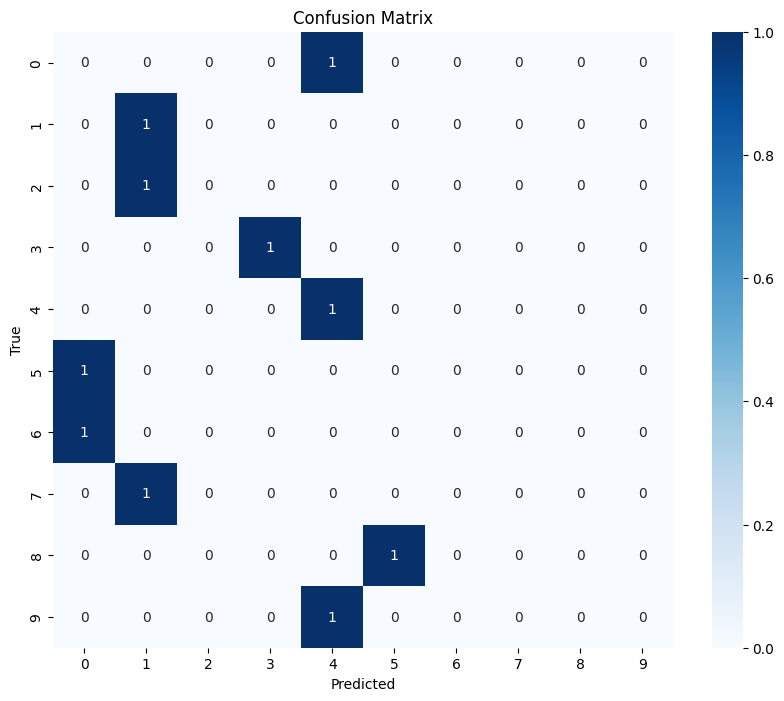

Participant 69 Accuracy: 30.00%


In [13]:
# Evaluation by participant
for participant, data in participant_data.items():
    print(f"\nEvaluating Participant {participant}")
    participant_test_dataset = ExperimentalDataset(data['test'][0], data['test'][1])
    participant_test_loader = DataLoader(participant_test_dataset, batch_size=32, shuffle=False)
    participant_accuracy = evaluate(fine_tuned_model, participant_test_loader, device, show_matrix=True)
    print(f'Participant {participant} Accuracy: {participant_accuracy:.2f}%')